Tokenized json1 object 1: ['name', 'node', 'a', 'description', 'this', 'is', 'node', 'a', 'file', 'j', '##son', '##1']
Embedding shape for json1 object 1: (1, 768)
Tokenized json1 object 2: ['name', 'node', 'b', 'description', 'this', 'is', 'node', 'b', 'file', 'j', '##son', '##1']
Embedding shape for json1 object 2: (1, 768)
Tokenized json1 object 3: ['source', '##re', '##f', '1', 'target', '##re', '##f', '2', 'file', 'j', '##son', '##1']
Embedding shape for json1 object 3: (1, 768)
Tokenized json1 object 4: ['type', 'attack', '##pa', '##tter', '##n', 'name', 'http', 'flood', 'external', '##re', '##ference', '##s', 'source', '##name', 'cape', '##c', 'ur', '##l', 'https', '##cape', '##cm', '##it', '##re', '##org', '##da', '##tad', '##ef', '##ini', '##tions', '##48', '##8', '##ht', '##ml', 'external', '##id', 'cape', '##c', '##48', '##8', 'file', 'j', '##son', '##1']
Embedding shape for json1 object 4: (1, 768)
Tokenized json2 object 1: ['name', 'node', 'a', 'description', 'this', 'is',

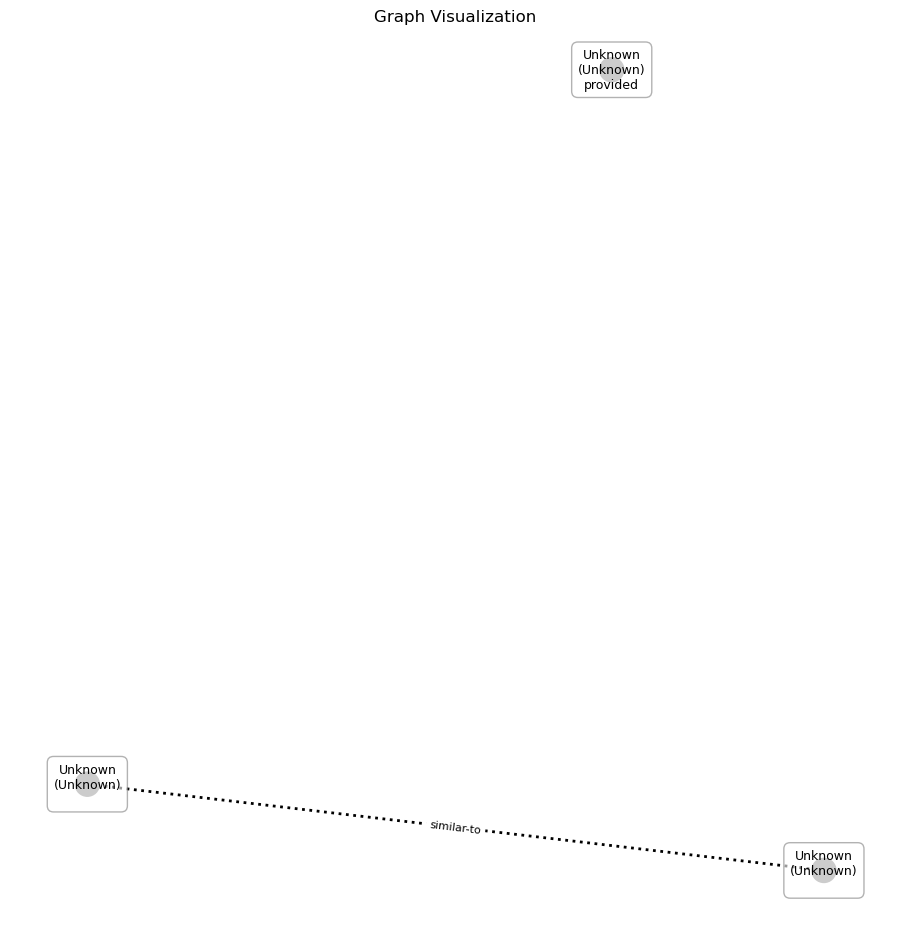

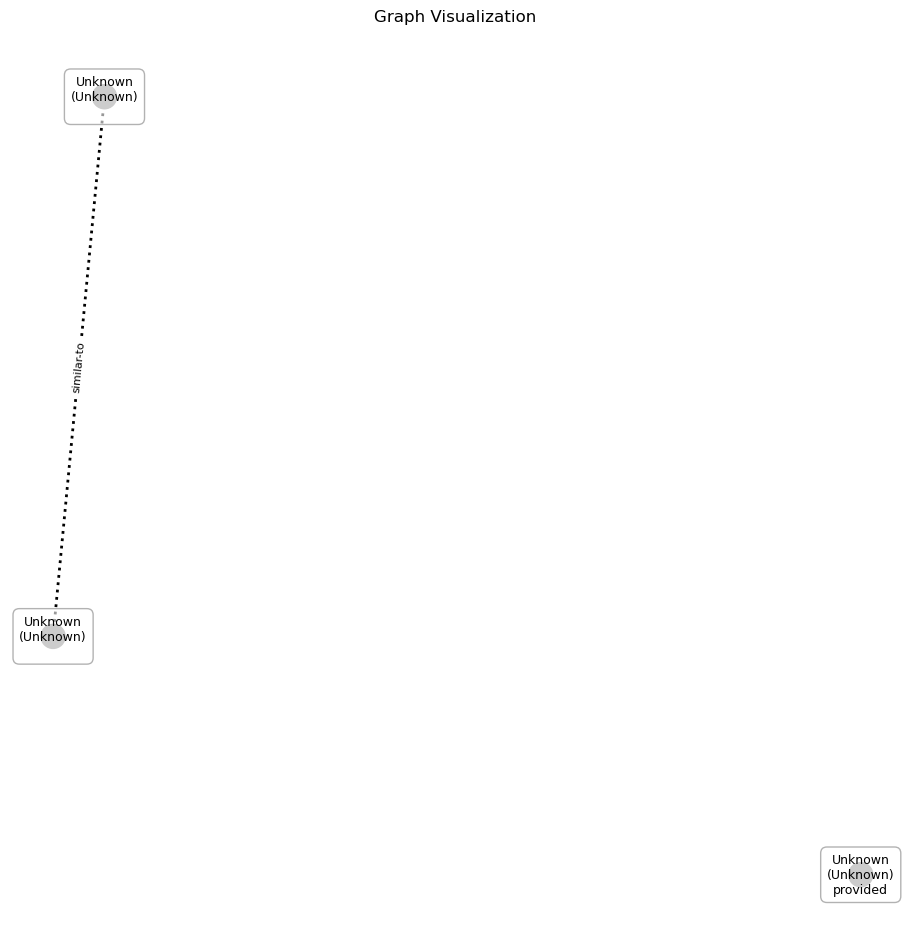

Node Distance (Simple): 0
Node Distance (Jaccard): 0.00
Key Distance (Simple): 1
Key Distance (Jaccard): 0.10
Value Distance (Simple): 0
Value Distance (Jaccard): 0.20
Graph Distance: 0.00
Jaccard distances saved to 'output_files\jaccard_distances.xlsx'.

Processing object with key: 3
Object type: node

Processing object with key: 4
Object type: edge

Processing object with key: 5
Object type: node
Key substitution (removal): name
Key substitution (addition): namenamename
Value substitution: external_references - [{'source_name': 'capec', 'url': 'https://capec.mitre.org/data/definitions/488.html', 'external_id': 'CAPEC-488'}] vs [{'source_nameSOURCE_NAME': 'capec', 'url': 'https://capec.mitre.org/data/definitions/488.html', 'external_id': 'CAPEC-488'}]

Processing object with key: 6
Object type: node

Final counts:
Nodes: 0 insertions, 0 deletions, 0 substitutions
Edges: 0 insertions, 0 deletions, 0 substitutions
Keys: 0 insertions, 0 deletions, 2 substitutions
Values: 0 insertions, 0 

In [6]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import string
import pandas as pd
import spacy
import os

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Create a new directory to save all files
output_dir = 'output_files'
os.makedirs(output_dir, exist_ok=True)

# Define global threshold variable
threshold = 0.8

def preprocess_text(text):
    """Preprocess text by lowercasing and removing punctuation."""
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    return text

def get_embeddings(text):
    """Get BERT embeddings for the given text."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Last hidden state (embedding)
    return outputs.last_hidden_state.mean(dim=1).numpy()

def save_tokenized_texts_combined(tokenized_texts, file_label):
    """Save combined tokenized texts to a file."""
    with open(os.path.join(output_dir, f"combined_tokenized_output_{file_label}.txt"), "w") as f:
        for tokenized_text in tokenized_texts:
            f.write(" ".join(tokenized_text) + "\n")

def save_embeddings_combined(embeddings, file_label):
    """Save combined embeddings as .npy file."""
    combined_embeddings = np.vstack(embeddings)
    np.save(os.path.join(output_dir, f"combined_embeddings_{file_label}.npy"), combined_embeddings)

def json_to_text(data, file_label):
    """Convert JSON entries to text for analysis and remove 'id' key. Add a 'file' key and determine node_or_edge."""
    texts = []
    embeddings = []
    tokenized_texts = []
    json_objects = {}
    original_ids = {}
    for i, entry in enumerate(data):
        original_id = entry.pop('id', None)  # Remove 'id' key and store it
        if original_id:
            original_ids[original_id] = entry  # Map original 'id' to entry

        entry['file'] = file_label  # Add 'file' key
        text = ". ".join(f"{key}: {value}" if not isinstance(value, list) else f"{key}: " + ", ".join(map(str, value)) for key, value in entry.items())
        text = preprocess_text(text)
        texts.append(text)

        # Tokenization
        tokenized_text = tokenizer.tokenize(text)
        print(f"Tokenized {file_label} object {i + 1}: {tokenized_text}")
        tokenized_texts.append(tokenized_text)

        # Get and save embeddings
        embedding = get_embeddings(text)
        print(f"Embedding shape for {file_label} object {i + 1}: {embedding.shape}")
        embeddings.append(embedding)
        
        # Determine node_or_edge
        if 'source_ref' in entry and 'target_ref' in entry:
            entry['node_or_edge'] = "edge"
        else:
            entry['node_or_edge'] = "node"
        
        json_objects[text] = {'entry': entry}
    return texts, embeddings, tokenized_texts, json_objects, original_ids

def load_json(file_path):
    """Load JSON data from a file with detailed error handling."""
    try:
        with open(file_path, 'r') as file:
            data = file.read()
            return json.loads(data)
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from file - {file_path}")
        print(f"Error details: {e}")
        print(f"Faulty JSON content:\n{data}")
        return None

def assign_encode_ids(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, original_ids1, original_ids2, threshold):
    combined_texts = texts1 + texts2
    combined_embeddings = np.vstack(embeddings1 + embeddings2)
    combined_json_objects = {**json_objects1, **json_objects2}

    similarity_matrix = cosine_similarity(combined_embeddings)
    encode_id = 1
    unmatched_encode_id = 10000
    encode_id_mapping = {}
    assigned_encode_ids = set()
    max_similarity = {}

    num_texts = len(combined_texts)
    comparison_matrix = np.zeros((num_texts, num_texts))

    for i in range(num_texts):
        for j in range(num_texts):
            if i != j:
                similarity = similarity_matrix[i, j]
                comparison_matrix[i, j] = similarity
                if similarity > threshold and combined_json_objects[combined_texts[i]]['entry']['file'] != combined_json_objects[combined_texts[j]]['entry']['file']:
                    if combined_texts[i] not in assigned_encode_ids or similarity > max_similarity.get(combined_texts[i], 0):
                        encode_id_mapping[combined_texts[i]] = encode_id
                        encode_id_mapping[combined_texts[j]] = encode_id
                        assigned_encode_ids.add(combined_texts[i])
                        assigned_encode_ids.add(combined_texts[j])
                        max_similarity[combined_texts[i]] = similarity
                        max_similarity[combined_texts[j]] = similarity
                        encode_id += 1

    for text in combined_texts:
        if text not in encode_id_mapping:
            encode_id_mapping[text] = unmatched_encode_id
            unmatched_encode_id += 1

    json_objects1 = {}
    json_objects2 = {}

    for text, obj in combined_json_objects.items():
        obj['entry']['encodeID'] = encode_id_mapping[text]
        if obj['entry']['file'] == 'json1':
            json_objects1[encode_id_mapping[text]] = obj['entry']
        else:
            json_objects2[encode_id_mapping[text]] = obj['entry']

    # Create a dictionary to map original IDs to encodeIDs
    id_to_encodeID = {original_id: obj['encodeID'] for original_id, obj in original_ids1.items()}
    id_to_encodeID.update({original_id: obj['encodeID'] for original_id, obj in original_ids2.items()})

    # Update source_ref and target_ref in relationship objects
    for obj in json_objects1.values():
        if obj['node_or_edge'] == 'edge':
            obj['source_ref'] = id_to_encodeID.get(obj['source_ref'], obj['source_ref'])
            obj['target_ref'] = id_to_encodeID.get(obj['target_ref'], obj['target_ref'])

    for obj in json_objects2.values():
        if obj['node_or_edge'] == 'edge':
            obj['source_ref'] = id_to_encodeID.get(obj['source_ref'], obj['source_ref'])
            obj['target_ref'] = id_to_encodeID.get(obj['target_ref'], obj['target_ref'])

    return json_objects1, json_objects2, comparison_matrix, combined_embeddings

def compare_nested_dicts(dict1, dict2):
    """Recursively compare two nested dictionaries."""
    if dict1 == dict2:
        return True

    if not isinstance(dict1, dict) or not isinstance(dict2, dict):
        return False

    for key in dict1:
        if key not in dict2:
            return False
        if not compare_nested_dicts(dict1[key], dict2[key]):
            return False

    for key in dict2:
        if key not in dict1:
            return False

    return True

def identify_node_or_edge_and_add_key(json_objects):
    """Identify if an object is a node or an edge based on the presence of two values matching encodeIDs of other objects,
    and add a new key-value pair indicating its type."""
    
    encode_ids = {entry['encodeID'] for entry in json_objects.values()}
    
    for obj in json_objects.values():
        values = set()
        for v in obj.values():
            if isinstance(v, list):
                for item in v:
                    if isinstance(item, dict):
                        values.update(item.values())
                    else:
                        values.add(item)
            elif isinstance(v, dict):
                values.update(v.values())
            else:
                values.add(v)
        
        if len(values.intersection(encode_ids)) >= 2:
            obj['node_or_edge'] = "edge"
        else:
            obj['node_or_edge'] = "node"
    
    return json_objects

def compare_objects(obj1, obj2):
    """Compare two objects, which can be dictionaries, lists, or primitive types."""
    if isinstance(obj1, dict) and isinstance(obj2, dict):
        return compare_nested_dicts(obj1, obj2)
    elif isinstance(obj1, list) and isinstance(obj2, list):
        if len(obj1) != len(obj2):
            return False
        return all(compare_objects(i, j) for i, j in zip(obj1, obj2))
    else:
        return obj1 == obj2

def compare_nested_dicts(dict1, dict2):
    """Recursively compare two nested dictionaries."""
    if dict1 == dict2:
        return True

    if not isinstance(dict1, dict) or not isinstance(dict2, dict):
        return False

    for key in dict1:
        if key not in dict2:
            return False
        if not compare_objects(dict1[key], dict2[key]):
            return False

    for key in dict2:
        if key not in dict1:
            return False

    return True


def save_json(data, file_path):
    """Save JSON data to a file."""
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

def build_graph(json_objects, suffix, color):
    """Build a graph based on JSON objects."""
    G = nx.Graph()
    valid_nodes = set()

    # Add nodes, ensuring unique IDs
    for key, obj in json_objects.items():
        if obj['node_or_edge'] != 'edge':  # Only add entities as nodes
            if obj.get('name') != 'Unknown Name':  # Avoid adding unknown name nodes
                unique_id = str(obj.get('encodeID')) + suffix
                node_name = f"{obj.get('encodeID')} ({obj['file']})"
                G.add_node(unique_id, description=obj.get('description', 'No description provided'))
                valid_nodes.add(unique_id)
        else:
            continue

    # Add edges, using unique IDs
    unique_edges = set()
    for obj in json_objects.values():
        if obj['node_or_edge'] == 'edge':
            source = str(obj.get('source_ref')) + suffix
            target = str(obj.get('target_ref')) + suffix
            edge = (source, target)
            if source in valid_nodes and target in valid_nodes and source != target:  # Ensure both nodes are valid and not the same
                G.add_edge(source, target)
                unique_edges.add(edge)
    return G


def visualize_graph(G):
    """Visualize a networkx graph with enhanced label formatting for readability."""
    num_nodes = len(G.nodes)
    figsize = get_optimal_figsize(num_nodes)
    k = get_optimal_k(num_nodes)

    plt.figure(figsize=figsize)  # Dynamically set figure size
    pos = nx.spring_layout(G, k=k)  # Dynamically set layout parameter

    # Draw nodes with their corresponding colors
    node_colors = [data.get('color', 'grey') for node, data in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)

    # Draw edges with specified styles and colors
    for (u, v, data) in G.edges(data=True):
        edge_style = data.get('style', 'dotted')
        edge_color = data.get('color', 'black')
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            style=edge_style,
            edge_color=edge_color,
            width=2
        )

    # Draw edge labels
    edge_labels = {(u, v): data.get('label', 'similar-to') for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Draw labels for nodes
    labels = {}
    for node, data in G.nodes(data=True):
        label = f"{data.get('label', 'Unknown')}\n({data.get('type', 'Unknown')})"
        description = data.get('description', 'No description provided')
        if description:
            doc = nlp(description)
            verbs = [token.text for token in doc if token.pos_ == 'VERB']
            label += f"\n{' '.join(verbs[:2])}"
        labels[node] = label

    for node, label in labels.items():
        x, y = pos[node]
        plt.text(x, y, label, fontsize=9, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='gray', alpha=0.6))

    plt.title('Graph Visualization')
    plt.axis('off')
    plt.show()

def get_optimal_figsize(num_nodes):
    """Determine an optimal figure size based on the number of nodes."""
    base_size = 10  # Base size for the figure
    scale_factor = 0.5  # Scale factor to adjust size
    return (base_size + num_nodes * scale_factor, base_size + num_nodes * scale_factor)

def get_optimal_k(num_nodes):
    """Determine an optimal k value for spring_layout based on the number of nodes."""
    base_k = 0.5  # Base k value
    scale_factor = 0.1  # Scale factor to adjust k
    return base_k + num_nodes * scale_factor

# Define node substitution cost function
def node_subst_cost(n1, n2):
    """Define cost for node substitution."""
    return 0 if n1 == n2 else 1

# Define edge substitution cost function
def edge_subst_cost(e1, e2):
    """Define cost for edge substitution."""
    return 0 if e1 == e2 else 1

def calculate_distances(json_objects1, json_objects2):
    """Calculate node distance, key distance, value distance, and graph distance."""
    def jaccard_distance(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return 1 - intersection / union if union != 0 else 1

    def set_distance(set1, set2):
        return abs(len(set1) - len(set2))

    # Node distance
    nodes1 = set(json_objects1.keys())
    nodes2 = set(json_objects2.keys())
    node_distance = set_distance(nodes1, nodes2)
    node_jaccard = jaccard_distance(nodes1, nodes2)

    # Key distance
    keys1 = set(k for obj in json_objects1.values() for k in obj.keys())
    keys2 = set(k for obj in json_objects2.values() for k in obj.keys())
    key_distance = set_distance(keys1, keys2)
    key_jaccard = jaccard_distance(keys1, keys2)

    # Value distance
    values1 = set(v for obj in json_objects1.values() for v in obj.values() if isinstance(v, str))
    values2 = set(v for obj in json_objects2.values() for v in obj.values() if isinstance(v, str))
    value_distance = set_distance(values1, values2)
    value_jaccard = jaccard_distance(values1, values2)

    # Graph distance (using node and edge comparison)
    G1 = build_graph(json_objects1, '_blue', 'blue')
    G2 = build_graph(json_objects2, '_red', 'red')
    graph_distance = nx.graph_edit_distance(G1, G2, node_subst_cost=node_subst_cost, edge_subst_cost=edge_subst_cost)

    print(f"Node Distance (Simple): {node_distance}")
    print(f"Node Distance (Jaccard): {node_jaccard:.2f}")
    print(f"Key Distance (Simple): {key_distance}")
    print(f"Key Distance (Jaccard): {key_jaccard:.2f}")
    print(f"Value Distance (Simple): {value_distance}")
    print(f"Value Distance (Jaccard): {value_jaccard:.2f}")
    print(f"Graph Distance: {graph_distance:.2f}")

def create_comparison_matrix(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, threshold):
    combined_embeddings = np.vstack(embeddings1 + embeddings2)
    similarity_matrix = cosine_similarity(combined_embeddings)

    num_texts1 = len(texts1)
    num_texts2 = len(texts2)
    comparison_data = []

    for i in range(num_texts1):
        row = []
        for j in range(num_texts2):
            similarity = similarity_matrix[i, num_texts1 + j]
            match = 1 if similarity > threshold else 0
            row.append(match)
        comparison_data.append(row)

    labels1 = [obj['encodeID'] for obj in json_objects1.values()]
    labels2 = [obj['encodeID'] for obj in json_objects2.values()]

    comparison_df = pd.DataFrame(comparison_data, index=labels1, columns=labels2)

    return comparison_df, similarity_matrix


def save_comparison_matrix_to_excel(comparison_df, similarity_matrix, file_path, labels1, labels2):
    """Save the comparison matrix and similarity values to an Excel file."""
    with pd.ExcelWriter(os.path.join(output_dir, file_path)) as writer:
        comparison_df.to_excel(writer, sheet_name='Comparison Matrix')

        # Add similarity values sheet with correct dimensions
        similarity_submatrix = similarity_matrix[:len(labels1), len(labels1):len(labels1)+len(labels2)]
        similarity_df = pd.DataFrame(similarity_submatrix, index=labels1, columns=labels2)
        similarity_df.to_excel(writer, sheet_name='Similarity Values')

def save_embeddings_to_excel(embeddings1, embeddings2, labels1, labels2, file_path, threshold):
    """Save aggregated embeddings and similarity matrix to an Excel file."""
    
    # Aggregate embeddings for JSON1 and JSON2 separately
    aggregated_embeddings1 = np.array([embedding.mean(axis=0) for embedding in embeddings1])
    aggregated_embeddings2 = np.array([embedding.mean(axis=0) for embedding in embeddings2])
    
    # Compute similarity matrix only for JSON1 vs JSON2
    similarity_matrix = cosine_similarity(aggregated_embeddings1, aggregated_embeddings2)
    
    # Create binary match matrix
    match_matrix = np.zeros_like(similarity_matrix)
    
    # Find maximum similarities above the threshold and update match matrix
    for i in range(similarity_matrix.shape[0]):
        max_sim_index = np.argmax(similarity_matrix[i])
        if similarity_matrix[i, max_sim_index] > threshold:
            match_matrix[i, max_sim_index] = 1
    
    for j in range(similarity_matrix.shape[1]):
        max_sim_index = np.argmax(similarity_matrix[:, j])
        if similarity_matrix[max_sim_index, j] > threshold:
            match_matrix[max_sim_index, j] = 1
    
    # Create DataFrames for similarity and match matrices
    similarity_df = pd.DataFrame(similarity_matrix, index=labels1, columns=labels2)
    match_df = pd.DataFrame(match_matrix, index=labels1, columns=labels2)
    
    # Save to Excel
    with pd.ExcelWriter(os.path.join(output_dir, file_path)) as writer:
        similarity_df.to_excel(writer, sheet_name='Similarity Matrix')
        match_df.to_excel(writer, sheet_name='Match Matrix')

    print(f"Embeddings and similarity matrices saved to '{file_path}'.")

def save_jaccard_distances_to_excel(similarity_matrix, labels1, labels2, json_objects1, json_objects2, file_path, G1, G2):
    num_texts1 = len(labels1)
    num_texts2 = len(labels2)
    jaccard_distances = []

    similarity_submatrix = similarity_matrix[:num_texts1, :num_texts2]

    if similarity_submatrix.shape != (num_texts1, num_texts2):
        raise ValueError(f"Expected submatrix shape ({num_texts1}, {num_texts2}), but got {similarity_submatrix.shape}")

    for i in range(num_texts1):
        for j in range(num_texts2):
            intersection = similarity_submatrix[i, j]
            union = 1
            jaccard_distance = 1 - intersection / union if union != 0 else 1

            # Ensure encodeID exists before accessing node_or_edge
            try:
                type1 = json_objects1[labels1[i]]['node_or_edge']
                type2 = json_objects2[labels2[j]]['node_or_edge']
            except KeyError as e:
                print(f"KeyError: {e} for labels1[{i}]: {labels1[i]} and labels2[{j}]: {labels2[j]}")
                continue

            jaccard_distances.append({
                'Text 1 Index': i,
                'Text 2 Index': j,
                'Text 1 Label': labels1[i],
                'Text 2 Label': labels2[j],
                'Type 1': type1,
                'Type 2': type2,
                'Intersection (Cosine Similarity)': intersection,
                'Union': union,
                'Jaccard Distance': jaccard_distance
            })

    jaccard_df = pd.DataFrame(jaccard_distances)

    node_summary = jaccard_summary(
        set(obj['encodeID'] for obj in json_objects1.values()),
        set(obj['encodeID'] for obj in json_objects2.values()),
        'Node Distance'
    )

    key_summary = jaccard_summary(
        set(k for obj in json_objects1.values() for k in obj.keys()),
        set(k for obj in json_objects2.values() for k in obj.keys()),
        'Key Distance'
    )

    value_summary = jaccard_summary(
        set(v for obj in json_objects1.values() for v in obj.values() if isinstance(v, str)),
        set(v for obj in json_objects2.values() for v in obj.values() if isinstance(v, str)),
        'Value Distance'
    )

    graph_summary = jaccard_summary(
        set(G1.edges()),
        set(G2.edges()),
        'Graph Distance'
    )

    summary_df = pd.DataFrame([node_summary, key_summary, value_summary, graph_summary])

    cosine_df = pd.DataFrame(similarity_submatrix, index=labels1, columns=labels2)

    nodes_details = []
    edges_details = []

    for i in range(num_texts1):
        for j in range(num_texts2):
            type1 = json_objects1[labels1[i]]['node_or_edge']
            type2 = json_objects2[labels2[j]]['node_or_edge']
            if type1 == 'node' and type2 == 'node':
                nodes_details.append({
                    'Text 1 Index': i,
                    'Text 2 Index': j,
                    'Text 1 Label': labels1[i],
                    'Text 2 Label': labels2[j],
                    'Cosine Similarity': similarity_submatrix[i, j]
                })
            elif type1 == 'edge' and type2 == 'edge':
                edges_details.append({
                    'Text 1 Index': i,
                    'Text 2 Index': j,
                    'Text 1 Label': labels1[i],
                    'Text 2 Label': labels2[j],
                    'Cosine Similarity': similarity_submatrix[i, j]
                })

    nodes_df = pd.DataFrame(nodes_details)
    edges_df = pd.DataFrame(edges_details)

    with pd.ExcelWriter(file_path) as writer:
        cosine_df.to_excel(writer, sheet_name='Cosine Similarity')
        nodes_df.to_excel(writer, sheet_name='Nodes Details', index=False)
        edges_df.to_excel(writer, sheet_name='Edges Details', index=False)
        jaccard_df.to_excel(writer, sheet_name='Jaccard Distances', index=False)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)

    print(f"Jaccard distances saved to '{file_path}'.")

def jaccard_summary(set1, set2, label):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_distance = 1 - intersection / union if union != 0 else 1
    return {
        'Metric': f'{label} (Jaccard)',
        'Distance': jaccard_distance,
        'Intersection': intersection,
        'Union': union
    }

def calculate_detailed_distances(json_objects1, json_objects2, threshold):
    def compare_objects(obj1, obj2):
        key_i, key_d, key_s = 0, 0, 0
        value_i, value_d, value_s = 0, 0, 0
        is_different = False

        all_keys = set(obj1.keys()) | set(obj2.keys())
        for key in all_keys:
            if key not in ['file', 'node_or_edge', 'encodeID']:
                if key in obj1 and key in obj2:
                    if key.lower() != key.lower():  # Case-insensitive comparison
                        key_s += 1
                        is_different = True
                        print(f"Key substitution: {key}")
                    elif obj1[key] != obj2[key]:
                        value_s += 1
                        is_different = True
                        print(f"Value substitution: {key} - {obj1[key]} vs {obj2[key]}")
                elif key in obj1:
                    key_s += 1
                    is_different = True
                    print(f"Key substitution (removal): {key}")
                else:
                    key_s += 1
                    is_different = True
                    print(f"Key substitution (addition): {key}")

        return key_s, value_s, is_different

    node_s = 0
    edge_s = 0
    total_key_s = 0
    total_value_s = 0

    for key in set(json_objects1.keys()) | set(json_objects2.keys()):
        print(f"\nProcessing object with key: {key}")
        if key in json_objects1 and key in json_objects2:
            obj1, obj2 = json_objects1[key], json_objects2[key]
            print(f"Object type: {obj1['node_or_edge']}")
            key_s, value_s, is_different = compare_objects(obj1, obj2)
            
            if is_different:
                total_key_s += key_s
                total_value_s += value_s
                # We're not incrementing node_s or edge_s here anymore

    print(f"\nFinal counts:")
    print(f"Nodes: 0 insertions, 0 deletions, {node_s} substitutions")
    print(f"Edges: 0 insertions, 0 deletions, {edge_s} substitutions")
    print(f"Keys: 0 insertions, 0 deletions, {total_key_s} substitutions")
    print(f"Values: 0 insertions, 0 deletions, {total_value_s} substitutions")

    return [{
        "node_distance": node_s,
        "node_i": 0,
        "node_d": 0,
        "node_s": node_s,
        "edge_distance": edge_s,
        "edge_i": 0,
        "edge_d": 0,
        "edge_s": edge_s,
        "key_distance": total_key_s,
        "key_i": 0,
        "key_d": 0,
        "key_s": total_key_s,
        "value_distance": total_value_s,
        "value_i": 0,
        "value_d": 0,
        "value_s": total_value_s
    }]

def main():
    global threshold
    path1 = input("Enter the file path for JSON 1: ").strip('"')
    path2 = input("Enter the file path for JSON 2: ").strip('"')
        
    threshold = float(input("Enter the similarity threshold (e.g., 0.95): ").strip())

    data1 = load_json(path1)
    if data1 is None:
        return

    data2 = load_json(path2)
    if data2 is None:
        return

    texts1, embeddings1, tokenized_texts1, json_objects1, original_ids1 = json_to_text(data1, 'json1')
    texts2, embeddings2, tokenized_texts2, json_objects2, original_ids2 = json_to_text(data2, 'json2')

    combined_tokenized_texts = tokenized_texts1 + tokenized_texts2

    save_tokenized_texts_combined(combined_tokenized_texts, 'combined')
    save_embeddings_combined(embeddings1 + embeddings2, 'combined')

    json_objects1, json_objects2, comparison_matrix, combined_embeddings = assign_encode_ids(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, original_ids1, original_ids2, threshold)

    # Update the following lines to use the new identify_node_or_edge_and_add_key function
    json_objects1 = identify_node_or_edge_and_add_key(json_objects1)
    json_objects2 = identify_node_or_edge_and_add_key(json_objects2)

    save_embeddings_to_excel(embeddings1, embeddings2, 
        [obj['encodeID'] for obj in json_objects1.values()],
        [obj['encodeID'] for obj in json_objects2.values()], 
        'embeddings_and_similarity.xlsx', threshold)

    save_json(json_objects1, os.path.join(output_dir, 'normalized_data1.json'))
    save_json(json_objects2, os.path.join(output_dir, 'normalized_data2.json'))

    comparison_df, similarity_matrix = create_comparison_matrix(texts1, embeddings1, texts2, embeddings2, json_objects1, json_objects2, threshold)
    save_comparison_matrix_to_excel(comparison_df, similarity_matrix, 'comparison_matrix.xlsx', 
        [obj['encodeID'] for obj in json_objects1.values()], 
        [obj['encodeID'] for obj in json_objects2.values()])

    print("Comparison matrix saved to 'output_files/comparison_matrix.xlsx'.")

    G1 = build_graph(json_objects1, '_blue', 'blue')
    G2 = build_graph(json_objects2, '_red', 'red')

    visualize_graph(G1)
    visualize_graph(G2)

    calculate_distances(json_objects1, json_objects2)

    sub_similarity_matrix = similarity_matrix[:len(json_objects1), len(json_objects1):len(json_objects1)+len(json_objects2)]
    save_jaccard_distances_to_excel(sub_similarity_matrix, 
        [obj['encodeID'] for obj in json_objects1.values()], 
        [obj['encodeID'] for obj in json_objects2.values()], 
        json_objects1, json_objects2, os.path.join(output_dir, 'jaccard_distances.xlsx'), G1, G2)

    detailed_distances = calculate_detailed_distances(json_objects1, json_objects2, threshold)
    save_json(detailed_distances, os.path.join(output_dir, 'detailed_distances.json'))
    print("Detailed distances saved to 'output_files/detailed_distances.json'.")

if __name__ == "__main__":
    main()
